# GRAD CAM

## Import libraries

In [38]:
import tensorflow as tf
keras = tf.keras
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

import matplotlib.image as mpimg

## Load model

In [39]:
# Cargar tu modelo desde el archivo .h5
model_path = './trained_model.h5'  # Ajusta esta ruta a donde está tu archivo .h5
model = load_model(model_path)

In [40]:
# Nombre de la última capa convolucional del modelo
last_conv_layer_name = 'conv_layer_2' 

## Model Summary

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 100, 100, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 50, 50, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,196 (2.45 MB)

 Trainable params: 641,194 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [42]:
model_output = model.get_layer("dense_1").output

## Check last conv layer

In [43]:
# Crear el modelo grad_model que mapea las activaciones de la última capa convolucional y la salida
grad_model = keras.models.Model(
    model.inputs, [model.get_layer(last_conv_layer_name).output, model_output]
)

In [44]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [45]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model_output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [46]:
img_path = 'imagenes_todas/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
img_array = get_img_array(img_path, size=(100, 100))


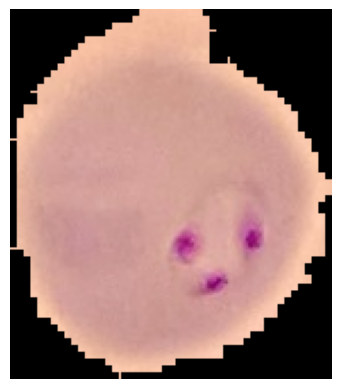

In [47]:
# Cargar y mostrar la imagen
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()

In [48]:
# Print what the top predicted class is
preds = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [49]:
preds

array([[ 6.752349, -6.569667]], dtype=float32)

In [50]:
model.layers

[<Rescaling name=rescaling, built=True>,
 <Conv2D name=conv_layer_1, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv_layer_2, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [51]:
last_conv_layer_name

'conv_layer_2'

In [52]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
# Display heatmap
plt.matshow(heatmap)
plt.show()